## 1. 프로젝트 기획

### 1.1 프로젝트 개요

일상생활에서 영어는 어디에서든지 발견이 가능합니다. 다양한 영어 단어들이 있다보니 처음보는 단어가 보일 때도 있는데, 일반적인 경우 처음 보는 단어에 대해서 자연스러운 발음으로 영어를 읽기가 어렵습니다. 

처음 보는 영단어의 발음을 알기 위해서는 영어사전에서 찾아서 발음기호를 보고 읽거나 네이버에서 제공하는 영어 단어사전 발음 서비스를 이용하여 따라 읽어야 합니다.

하지만 대부분의 경우 모르는 영단어가 나와도 알아내기 위한 과정이 생각보다 귀찮고 단계로 따지면 많습니다.

### 1.2 프로젝트 주제 선정

영단어를 찾는 과정을 간소화해서 모르는 단어도 쉽게 알 수 있는 서비스를 만드는 것을 프로젝트의 주제로 잡겠습니다.

1. OCR 기술을 사용하여 모르는 단어 이미지에 있는 영단어를 추출하고
2. 추출한 영단어의 발음을 네이버 API를 사용하여 발음을 알려주는

2개의 단계를 거쳐서 프로젝트를 진행하겠습니다.

In [1]:
# 기본 설치 패키지
import os
import re
import time
import numpy as np
from glob import glob
from collections import defaultdict

# 이미지 데이터 처리
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# keras-ocr 모델 불러오기
import keras_ocr

# tesseract 모델 불러오기
import pytesseract
from pytesseract import Output

# 예측된 영단어 발음 재생 패키지
import IPython.display as ipd
from gtts import gTTS

## 2. 사전학습된 OCR 모델 선정

### 2.1 keras 모델과 tesseract 비교하기

keras-ocr 모델과 tesseract 모델이 찾은 문장과 문장의 위치를 서로 비교해보겠습니다.

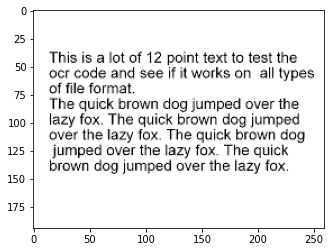

In [2]:
imgs = cv2.imread("./imgs/english.png")
imgs = np.array(imgs)
plt.imshow(imgs)
plt.show()

비교를 위하여 예제 이미지를 불러와서 확인해보겠습니다.

### 2.1.1 keras-ocr

In [3]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


사전에 학습이 완료된 keras_ocr 모델을 불러옵니다.

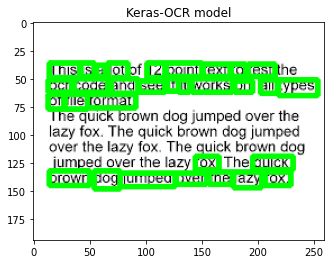

keras-ocr 걸리는 시간 : 38.52864456176758


In [4]:
def keras_ocr_predict(imgs, pipeline):

    cp_imgs = imgs.copy()
    prediction_group = pipeline.recognize([cp_imgs])
    prediction_group = dict(prediction_group[0])
    return prediction_group


def keras_ocr_imshow(imgs, prediction_group):
    cp_imgs = imgs.copy()

    for word in prediction_group:
        (x, y, w, h) = (prediction_group[word][0, 0], 
                        prediction_group[word][0, 1],
                        prediction_group[word][2, 0],
                        prediction_group[word][2, 1]
                       )
        cv2.rectangle(cp_imgs, (x, y), (w, h), (0, 255, 0), 3)

    plt.imshow(cp_imgs)
    plt.title("Keras-OCR model")
    plt.show()
    


start = time.time()

prediction_group = keras_ocr_predict(imgs, pipeline)
keras_ocr_imshow(imgs, prediction_group)

end = time.time()
print(f"keras-ocr 걸리는 시간 : {end - start}")


### 2.2.2 Tesseract OCR

Tesseract 모델을 설치합니다.

- sudo apt install tesseract-ocr
- sudo apt install libtesseract-dev

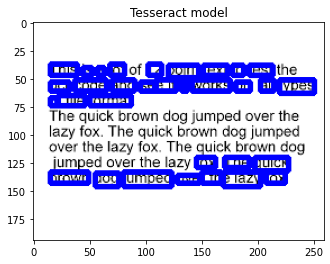

keras-ocr 걸리는 시간 : 0.6770927906036377


In [5]:
def tesseract_predict(imgs):
    cp_imgs = imgs.copy()
    custom_oem_psm_config = r'--oem 3 --psm 3'
    data = pytesseract.image_to_data(
        cp_imgs,
        lang = 'eng',
        config = custom_oem_psm_config,
        output_type = Output.DICT
    )

    dict_data = defaultdict()
    for ind, word in enumerate(data["text"]):
        if word != "":
            dict_data[word] = np.array(
                [data["left"][ind], 
                data["top"][ind], 
                data["width"][ind],
                data["height"][ind]]
            )
    dict_data = dict(dict_data)
    return dict_data


def tesseract_imshow(imgs, dict_data):
    cp_imgs = imgs.copy()
    for word in dict_data:
        (x, y, w, h) = (dict_data[word][0], 
                        dict_data[word][1],
                        dict_data[word][2],
                        dict_data[word][3]
                       )
        cv2.rectangle(cp_imgs, (x, y), (x + w, y + h), (0, 0, 255), 3)

    plt.imshow(cp_imgs)
    plt.title("Tesseract model")
    plt.show()
    
start = time.time()
    

dict_data = tesseract_predict(imgs)    
tesseract_imshow(imgs, dict_data)
    
end = time.time()
print(f"keras-ocr 걸리는 시간 : {end - start}")

### 2.2 두 모델 성능 비교하기

모델의 성능을 비교하는 방법으로 해당 [링크](https://deview.kr/data/deview/2019/presentation/[123]%EB%AC%B8%EC%9E%90%EC%9D%B8%EC%8B%9D(OCR),+%EC%96%BC%EB%A7%88%EB%82%98+%EC%A0%95%ED%99%95%ED%95%98%EC%A7%80+(%EB%AC%B8%EC%9E%90%EC%9D%B8%EC%8B%9D+%EC%84%B1%EB%8A%A5%EC%9D%84+%EC%A0%95%ED%99%95%ED%95%98%EA%B2%8C+%EC%B8%A1%EC%A0%95%ED%95%98%EB%8A%94+%EB%B0%A9%EB%B2%95).pdf)에 있는 신규 방법을 기준으로 성능을 측정해보겠습니다.

In [6]:
def imgs_load(data_path):
    tmp = cv2.imread(data_path)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    tmp = np.array(tmp)
    return tmp


data_path = glob("./imgs/*.jpeg")
data_set = list(map(lambda x: imgs_load(x), data_path))

In [7]:
tesseract_set = list(map(lambda x : tesseract_predict(x) , data_set))
kerasocr_set = list(map(lambda x : keras_ocr_predict(x, pipeline) , data_set))

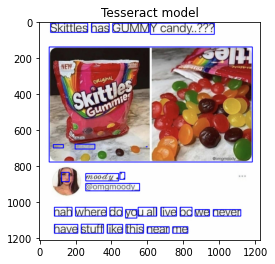

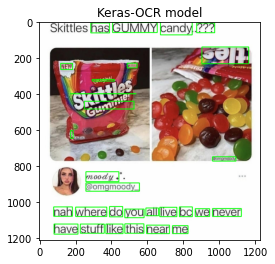

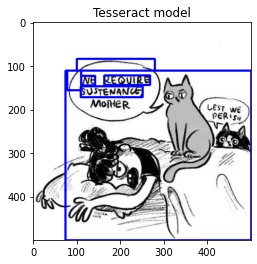

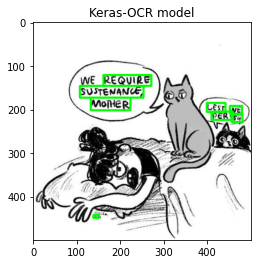

In [8]:
for i in range(len(data_set)):
    tesseract_imshow(data_set[i], tesseract_set[i])
    keras_ocr_imshow(data_set[i], kerasocr_set[i])

앞서 링크에서 언급된 신규 방법인 PopEval 기법을 사용하여 두 모델의 성능을 비교해보겠습니다.

In [9]:
true = [
    "Skittles has GUMMY candy..??? new original Skittelse GUMMIE ttles moody @omgmoody moody nah where do you all live bc we never have stuff like this near me",
    "WE REQUIRE SUSTENANCE, MOTHER LEST WE PERISIT"
    
]
split_true = list(map(lambda x: x.split() ,true))

split_tesseract_set = list(map(lambda x: [i for i in x.keys() if i != " "], tesseract_set))
split_kerasocr_set = list(map(lambda x: [i for i in x.keys() if i != " "], kerasocr_set))

PopEval 방법은 라벨링 되어진 실제값이 존재해야 하기 때문에 데이터가 적은 경우 직접 라벨링을 해야합니다. 지금 가져온 데이터들은 구글에서 가져온 무료 이미지이기 때문에 직접 라벨링을 해주겠습니다.

In [10]:
def word_f1_score(true, pred):
    """
    desc 
        OCR 모델이 하나의 단어를 찾았을 때, 
        알파벳을 잘 예측하였는지 점수를 매김
    args
        true : 실제 데이터에서 나온 단어. str
        pred : 예측 데이터에서 나온 단어. str
    retn
        PopEval 지표 기반의 F1-score. float
    """
    true_value = list(true.lower())
    pred_value = list(pred.lower())

    true_num_word = len(true_value)
    pred_num_word = len(pred_value)

    correct_num_word = 0
    for char in pred_value:
        if char in true_value:
            true_value.remove(char)
            correct_num_word += 1

    # recall = 정답으로 맞춘 글자 수 / 실제 데이터의 글자 수
    recall = correct_num_word / true_num_word
    # precision = 정답으로 맞춘 글자 수 / 예측한 데이터의 글자 수
    precision = correct_num_word / pred_num_word
    f1_score = 2 / ((1 / (recall + 1e-5) ) + (1 / (precision + 1e-5)) + 1e-5)
    return f1_score


def remove_blank(word_list):
    result = []
    for i in word_list:
        if not re.findall("[ ]+", i):
            result += [i]
    return result


def total_f1_score(true_list, pred_list):
    """
    desc 
        하나의 데이터에서 나온 word F1-score의 평균을
        반환합니다.
    args
        true : 실제 데이터에서 나온 단어들. list
        pred : 예측 데이터에서 나온 단어들. list
    retn
        PopEval 평균 word F1-score . float
    """    
    total_tmp = []
    
    for pred in pred_list:
        tmp = []
        for true in true_list:
            tmp += [word_f1_score(true, pred)]
        total_tmp += [max(tmp)]

    f1_score_mean = sum(total_tmp) / len(total_tmp)    
    return f1_score_mean

PopEval 지표를 구하기 위해서 코드로 구현을 하였습니다.  
제대로 인식이 되었는지 단어별로 F1-score를 구하고 단어별로 구해진 F1-score들의 평균을 한 데이터의 F1-score로 사용을 합니다.

데이터가 여러개인 경우 각 데이터별 F1-score를 구하여 평균을 사용하여 해당 모델의 총 F1-score를 구하여 줍니다.

In [11]:
num_images = len(true)
result = []
for i in range(num_images):
    # 하나의 결과가 예측된 데이터 불러오기
    tesser_pred_one_data = split_tesseract_set[i]
    keras_pred_one_data = split_kerasocr_set[i]
    true_one_data = split_true[i]
    
    # 예측된 데이터에서 공백 제거하기
    tesser_pred_one_data = remove_blank(tesser_pred_one_data)
    keras_pred_one_data = remove_blank(keras_pred_one_data)
    true_one_data = remove_blank(true_one_data) 
    
    # 한 데이터의 f1_score 구하기
    keras_ocr_f1_score = total_f1_score(true_one_data, keras_pred_one_data)
    tesser_f1_score = total_f1_score(true_one_data, tesser_pred_one_data)
    
    result += [(keras_ocr_f1_score, tesser_f1_score)]

keras_ocr, tesser = np.average(result, axis = 0)
    
print(f"Keras - OCR 모델의 PopEval 지표 기반 F1-score : {keras_ocr}")
print(f"Tesseract 모델의 PopEval 지표 기반 F1-score : {tesser}")

Keras - OCR 모델의 PopEval 지표 기반 F1-score : 0.8590086111892004
Tesseract 모델의 PopEval 지표 기반 F1-score : 0.9123719862241004


결과적으로는 비록 2개의 데이터만을 사용하였지만 Keras-OCR 모델과 Tesseract 모델중에서 PopEval 지표를 기반으로 더 좋은 성능을 가진 모델은 F1-score가 더 높은 Tesseract 모델이라고 생각할 수 있습니다.

## 3. 선정된 모델로 영어발음 듣기

Tesseract 모델의 결과물들의 영어발음을 듣기 위해서 gtts 패키지를 설치하여 줍니다.
- !pip install gtts

In [32]:
total_strings = []
for data in tesseract_set:
    strings = " ".join(list(data.keys()))
    strings = strings.strip()
    strings = re.sub("[ ]+", " ", strings)
    total_strings += [strings]

영어 선생님이 알아보기 쉽게 쓸모없는 빈칸들은 제거해주겠습니다.

In [42]:
idx_data = 0
words = list(tesseract_set[idx_data].keys())
print(f"해당 이미지에서 나온 단어의 종류 : {words}")
outputs = gTTS(text = total_strings[idx_data], lang = "en", slow = False)
outputs.save("output.wav")
ipd.Audio('output.wav') # load a local WAV file

해당 이미지에서 나온 단어의 종류 : ['Skittles', 'has', 'GUMMY', 'candy..???', ' ', 'Se', 'Fe', ':', 'es', 'moody.', '.', '@omgmoody_', 'nah', 'where', 'do', 'you', 'all', 'live', 'bc', 'we', 'never', 'have', 'stuff', 'like', 'this', 'near', 'me']


OCR 모델을 기반으로 나온 텍스트들을 gtts 패키지를 사용하여 음성으로 나올 수 있는 일련의 과정을 완성하였습니다.

## 4. 회고

- 처음에 PopEval 지표를 사용해서 정량적 지표를 만들면서 어떻게 구현하여 볼지 많이 고민하였고 F1-score를 만들어주는 기준도 직접 설계하는데도 생각보다 시간이 걸렸지만 의미있는 시간이었던거 같습니다.
- PopEval 지표를 사용하려면 라벨링이 되어진 데이터(OCR한 결과 텍스트의 유무)가 필요하여 이미 만들어진 데이터셋이나 벤치마크 데이터셋을 찾으려고 했습니다. 하지만 완성된 데이터셋중에는 원하는 형태의 데이터가 없었고, 벤치마크 데이터셋중에서는 coco_text 라는 데이터셋이 존재했지만 annotation만 다운로드 받고 image 데이터는 다운받기 까다로워서 간단한 데이터만 사용하였습니다. 기회가 되면 coco_text 데이터셋을 사용하여 보고 싶습니다.